# Data Scientist Take-Home FreshFlow


In this notebook, we will perform several approaches for time series processing:

- Brief description of the data used.
- Data cleaning
- Data prepreration
- Seasonal adjustment using moving averages to obtain consumption corrected for seasonal variations (CVS).
- Modeling with Holt-Winters and SARIMA methods and calculation of main metrics (MSE, MAE, RMSE, MAPE...).
- Prediction of sales_quantity per item per day
- Report of the quality of models

## 1- Brief description of  the source data

In [2]:
#Importing the initial libraries required for our analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
# import dataset 
df = pd.read_csv("data (1).csv",sep=",")

In [4]:
df.head()

,Unnamed: 0,day,item_number,item_name,purchase_price,suggested_retail_price,orders_quantity,sales_quantity,revenue
0,0,2022-02-09,80317483,ROMA TOMATEN ES I 500G SF,0.92,1.49,0.0,16.0,23.55
1,1,2022-02-09,80317483,ROMA TOMATEN ES I 500G SF,0.92,1.49,0.0,16.0,23.55
2,2,2022-02-09,80101923,SL MANDARINEN BEH.ES I 750G GS,2.05,3.49,0.0,3.0,10.47
3,3,2022-02-09,80101923,SL MANDARINEN BEH.ES I 750G GS,2.05,3.49,0.0,3.0,10.47
4,4,2022-02-09,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.64,0.99,0.0,13.0,12.84


In [5]:
df.columns

Index(['Unnamed: 0', 'day', 'item_number', 'item_name', 'purchase_price',
       'suggested_retail_price', 'orders_quantity', 'sales_quantity',
       'revenue'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1878 entries, 0 to 1877
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              1878 non-null   int64  
 1   day                     1878 non-null   object 
 2   item_number             1878 non-null   int64  
 3   item_name               1878 non-null   object 
 4   purchase_price          1878 non-null   float64
 5   suggested_retail_price  1878 non-null   float64
 6   orders_quantity         1878 non-null   float64
 7   sales_quantity          1878 non-null   float64
 8   revenue                 926 non-null    float64
dtypes: float64(5), int64(2), object(2)
memory usage: 132.2+ KB


In [7]:
df.describe(include = "all")

,Unnamed: 0,day,item_number,item_name,purchase_price,suggested_retail_price,orders_quantity,sales_quantity,revenue
count,1878.000000,1878,1.878000e+03,1878,1878.000000,1878.000000,1878.000000,1878.000000,926.000000
unique,NaN,313,NaN,3,NaN,NaN,NaN,NaN,NaN
top,NaN,2022-02-09,NaN,ROMA TOMATEN ES I 500G SF,NaN,NaN,NaN,NaN,NaN
freq,NaN,6,NaN,626,NaN,NaN,NaN,NaN,NaN
mean,938.500000,NaN,8.014925e+07,NaN,1.216796,1.941402,8.602769,8.235357,21.207775
std,542.276221,NaN,1.227237e+05,NaN,0.568129,0.936656,14.981958,11.510945,13.069028
min,0.000000,NaN,8.002835e+07,NaN,0.520000,0.660000,0.000000,0.000000,1.490000
25%,469.250000,NaN,8.002835e+07,NaN,0.674928,1.055314,0.000000,0.000000,12.847500
50%,938.500000,NaN,8.010192e+07,NaN,0.978451,1.546338,0.000000,0.000000,19.220000
75%,1407.750000,NaN,8.031748e+07,NaN,1.991321,3.216415,18.000000,15.000000,27.430000


We can notice that we have some nuls on the "revenue", we need to treat that after.

In [8]:
df['item_number'].unique()

array([80317483, 80101923, 80028349], dtype=int64)

We have 3 products

In [9]:
print(df['day'].min(),df['day'].max())

2021-04-03 2022-02-09


The range of the period is from date "2021-04-03" to date "2022-02-09". We have almost 10 months of history. 

In [ ]:
# Show evolution of the target over time
fig = plt.figure(figsize=(20,12))
sns.lineplot(data=df, x=df['day'],  y=df['sales_quantity'], hue=df['item_number'])
#plt.title("", fontsize=22)
plt.show()

We may think thar they are missing values as we see a trough in the curve. We need to be sure about having all data and if not we will propose some solutions.
We can also notice some outliers like peaks in the curve. We will do the necessary to treat them

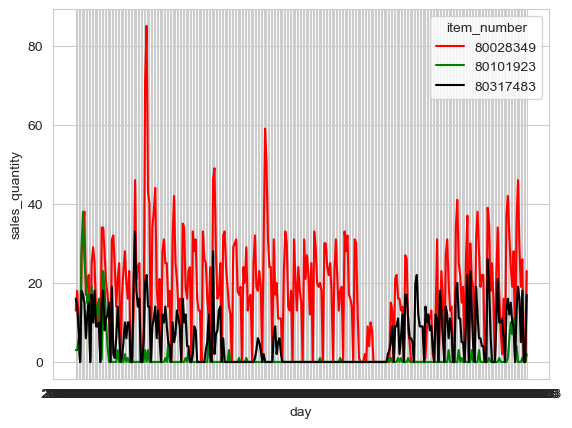

<Figure size 1000x600 with 0 Axes>

In [26]:
fig = plt.figure()
palette = {"red", "green","blue"}
sns.lineplot(data=df, x=df['day'],  y=df['sales_quantity'],hue=df['item_number'],palette=['red','green','black'])
# adjust the figure size
plt.figure(figsize=(10,6))

plt.show()

The 3 products has not the same way of sale. The are too different, The red one has the best sellers_quantity and the green has the worst.It must be ensured before validating this conclusion, that these sales are relative to the quantities received. So let's check the difference between "sales_quantity" and "orders_quantity"

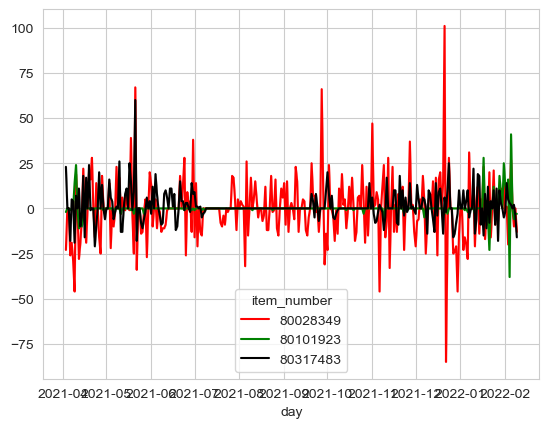

<Figure size 1000x600 with 0 Axes>

In [72]:
fig = plt.figure()
palette = {"red", "green","blue"}
sns.lineplot(data=df, x=df.index,  y=df['orders_quantity']-df['sales_quantity'],hue=df['item_number'],palette=['red','green','black'])
# adjust the figure size
plt.figure(figsize=(10,6))

plt.show()

there is negative values wich means that the store bought the whole quantity of the day and a previsous stock. 
The green product may have best sellers thant the black. Any way we do not sell the 3 products in the same way

## 2- Data cleaning

In [10]:
#remove non-essential columns
df = df.drop('Unnamed: 0', axis=1)

In [16]:
#check if there are duplicated lignes 
df.duplicated().sum() #939 duplicated lignes
df = df.drop_duplicates()

In [67]:
#treat the data features
df = df.set_index('day').copy()    

In [32]:
df.sort_index(inplace=True)

In [58]:
#convert "day" to datetime
df.index = pd.to_datetime(df.index)
df.index=df.index.strftime("%Y-%m-%d")


In [64]:
#Extract from the date, the day of the week , the month and the year
df.index = pd.to_datetime(df.index)

df['day_of_week'] = df.index.strftime('%A')
df['month'] = df.index.strftime('%B')
df['year'] = df.index.strftime('%Y')

In [18]:
df['revenue'].isnull().sum()
#476values are null

476

For these zero values, we can assimilate the average income for this product. Or to assume that today's stock has been completely sold is to replace it with orders_quantity*purchase_price. We will choose the second suggestion

In [19]:
df['revenue'].fillna(df['orders_quantity']*df['purchase_price'], inplace=True)

In [20]:
df['revenue'].isnull().sum()

0

In [ ]:
# find if there is missing days
daily_series = data.index
missing_values_count = daily_series.isna().sum()
missing_values_count

## 3- Data visialisation

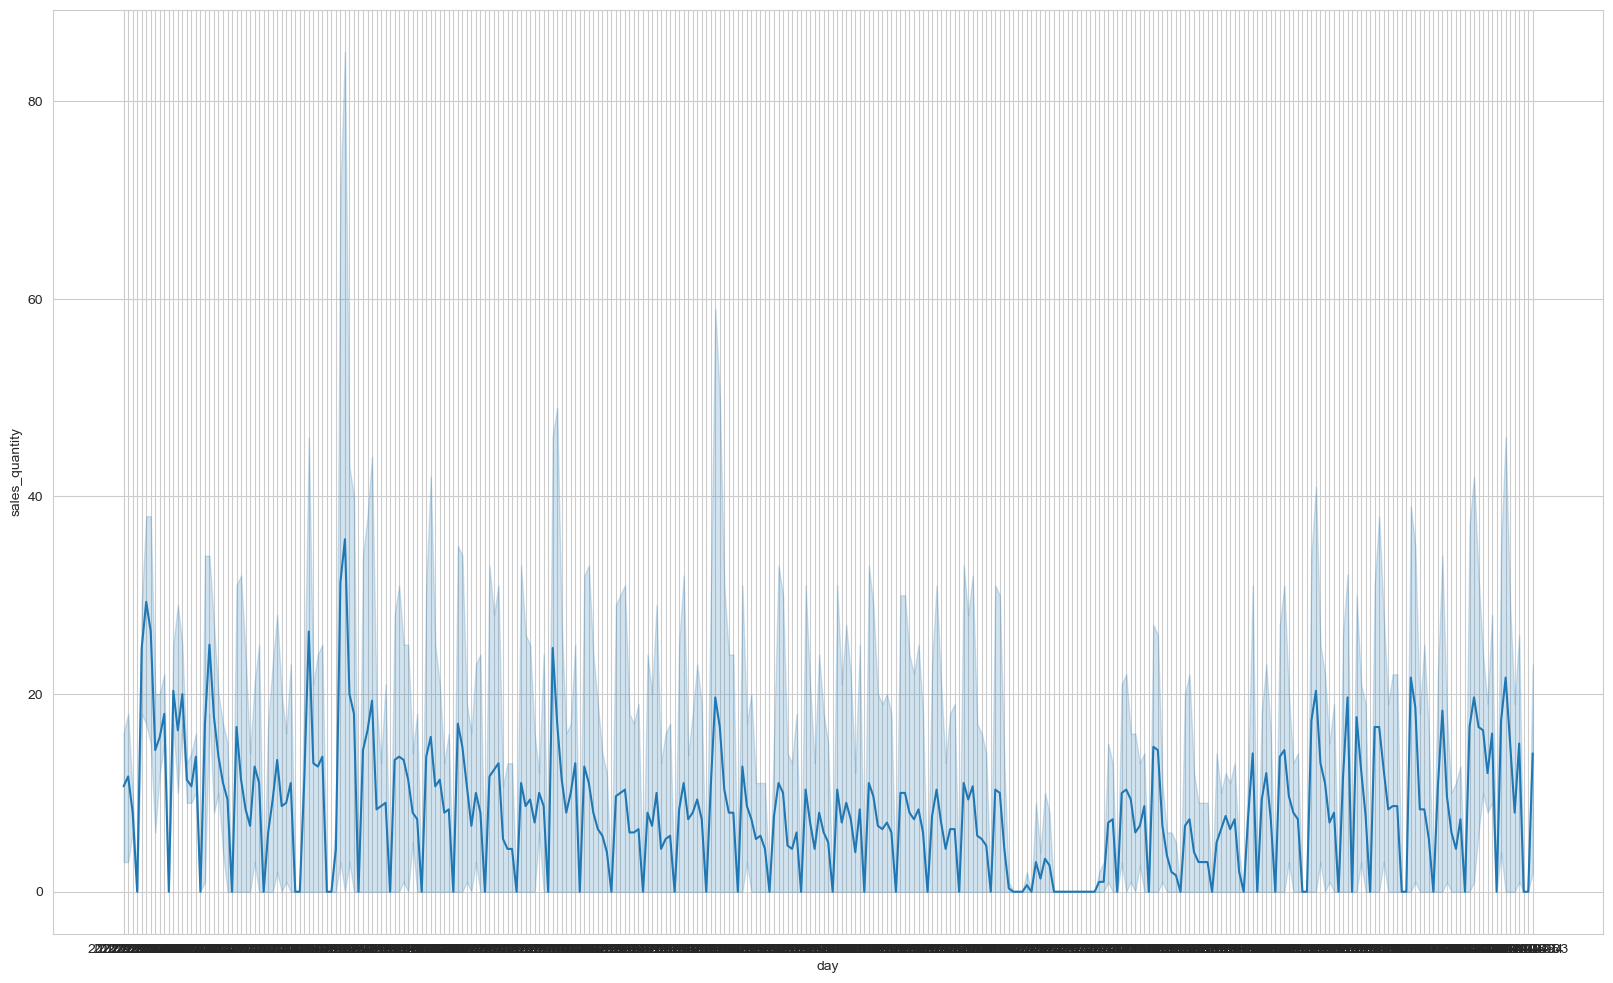

In [33]:
# Show evolution of the target over time
fig = plt.figure(figsize=(20,12))
sns.lineplot(data=df, x=df['day'],  y=df['sales_quantity'])
#plt.title("", fontsize=22)
plt.show()

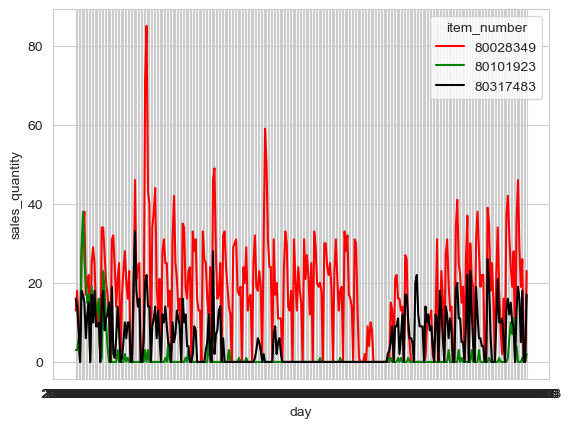

<Figure size 1000x600 with 0 Axes>

In [34]:
ig = plt.figure()
palette = {"red", "green","blue"}
sns.lineplot(data=df, x=df['day'],  y=df['sales_quantity'],hue=df['item_number'],palette=['red','green','black'])
# adjust the figure size
plt.figure(figsize=(10,6))

plt.show()

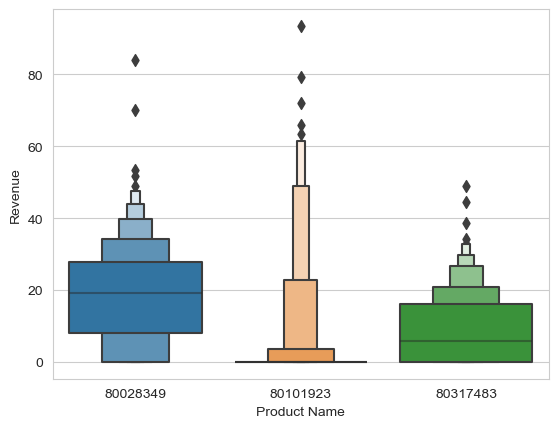

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Création du boxenplot
sns.boxenplot(x="item_number", y="revenue", data=df)

# Définition des labels des axes
plt.xlabel("Product Name")
plt.ylabel("Revenue")

# Affichage du plot
plt.show()

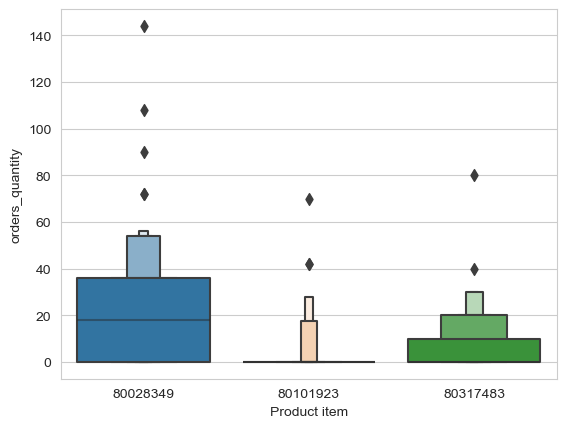

In [24]:
# Création du boxenplot
sns.boxenplot(x="item_number", y="orders_quantity", data=df)

# Définition des labels des axes
plt.xlabel("Product item")
plt.ylabel("orders_quantity")

# Affichage du plot
plt.show()

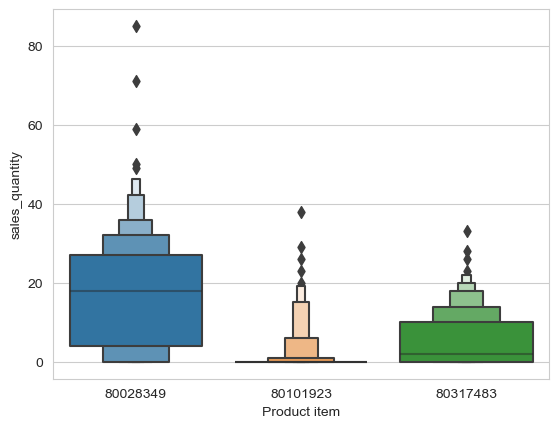

In [25]:
# Création du boxenplot
sns.boxenplot(x="item_number", y="sales_quantity", data=df)

# Définition des labels des axes
plt.xlabel("Product item")
plt.ylabel("sales_quantity")

# Affichage du plot
plt.show()

## 3- Data preperation 

In [26]:
# Calculate profit margin for each product
df['profit_margin'] = df['suggested_retail_price'] - df['purchase_price']


In [27]:
#calculate the rest quantity per day
df['rest_quantity']=df['orders_quantity']-df['sales_quantity']

In [28]:
df.head()

,day,item_number,item_name,purchase_price,suggested_retail_price,orders_quantity,sales_quantity,revenue,profit_margin,rest_quantity
0,2022-02-09,80317483,ROMA TOMATEN ES I 500G SF,0.92,1.49,0.0,16.0,23.55,0.57,-16.0
2,2022-02-09,80101923,SL MANDARINEN BEH.ES I 750G GS,2.05,3.49,0.0,3.0,10.47,1.44,-3.0
4,2022-02-09,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.64,0.99,0.0,13.0,12.84,0.35,-13.0
6,2022-02-08,80317483,ROMA TOMATEN ES I 500G SF,0.92,1.49,10.0,14.0,20.71,0.57,-4.0
8,2022-02-08,80101923,SL MANDARINEN BEH.ES I 750G GS,2.05,3.49,0.0,3.0,9.89,1.44,-3.0


Our data is ready for training

In [31]:
# Export Data frame for training part 
df.to_csv('data_input.csv', index=False)


### Désaisonnalisation par moyennes mobiles
Une moyenne mobile est une combinaison linéaire d'instants passés et futurs de notre série temporelle. L'enjeu est de trouver une moyenne mobile qui laisse la tendance invariante, qui absorbe la saisonnalité et qui réduit le résidu :

Notre série temporelle :  Xt=Tt+St+εt
 
Si on applique une moyenne mobile  M
  sur la série, nous obtenons :  MXt=MTt+MSt+Mεt
 
Ses propriétés idéales seront donc :

MTt=Tt
 
MSt=0
 
Mεt
  faible
Ici, nous allons utiliser la fonction "seasonal_decompose" du package statsmodels :

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

Prévision de la consommation
Méthode de Holt-Winters (lissage exponentiel)

In [ ]:
x_train = x["2012":"2018"]
x_test = x["2019"]
y_train = np.log(x_train)
y_test = np.log(x_test)

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing
hw_ln = ExponentialSmoothing(np.asarray(y_train), seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred_ln = hw_ln.forecast(12)